# Time delay-cosmography with uncertain PSF

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/lenstronomy/lenstronomy)


For further information, please get in touch with the lenstronomy developers.

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    %pip install lenstronomy

# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

## simulation choices

/tmp/ipykernel_245454/1537311550.py:17: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  kernel_blurred = ndimage.filters.gaussian_filter(kernel, 0.5, mode='nearest', truncate=5)
/tmp/ipykernel_245454/1537311550.py:19: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(kernel))


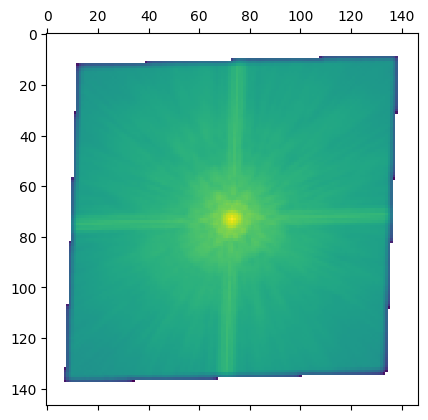

/tmp/ipykernel_245454/1537311550.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(kernel_blurred))


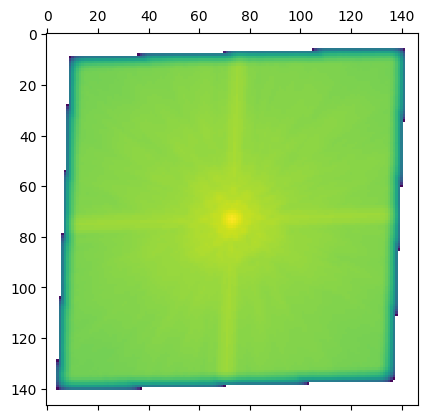

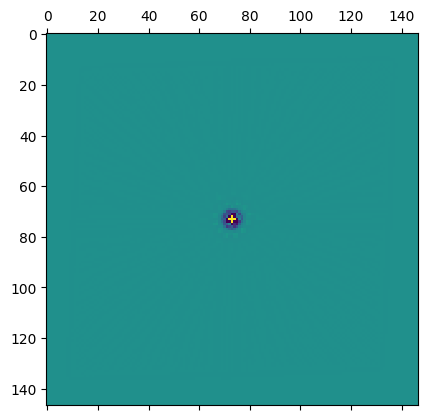

In [2]:

# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


# import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Data/PSF_TinyTim/psf_example.fits')
kernel = pyfits.getdata(psf_filename)

# blurr the PSF, this will be our starting point estimate
import scipy.ndimage as ndimage
kernel_blurred = ndimage.filters.gaussian_filter(kernel, 0.5, mode='nearest', truncate=5)

plt.matshow(np.log10(kernel))
plt.show()

plt.matshow(np.log10(kernel_blurred))
plt.show()

plt.matshow(kernel - kernel_blurred, vmin=-0.001, vmax=0.001)
plt.show()

    
# data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)
# generate the psf variables
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf_true = {'psf_type': psf_type, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}

kernel_cut_blurred = kernel_util.cut_psf(kernel_blurred, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut_blurred}
psf_class_true = PSF(**kwargs_psf_true)
psf_class = PSF(**kwargs_psf)


/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(
/tmp/ipykernel_245454/2468647952.py:78: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


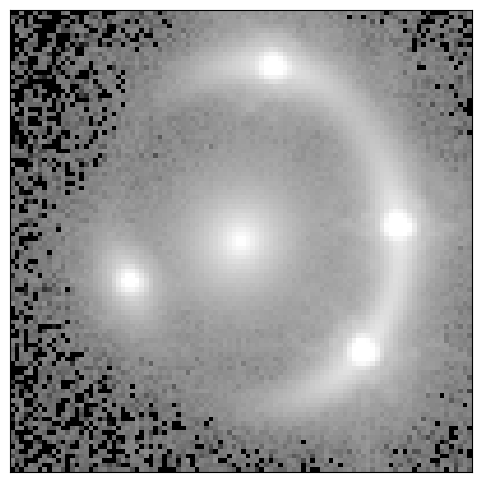

In [3]:
# lensing quantities
gamma1, gamma2 = param_util.shear_polar2cartesian(phi=-np.pi/2, gamma=0.05)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  # shear values
kwargs_pemd = {'theta_E': 1.66, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model

# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['EPL', 'SHEAR']
kwargs_lens = [kwargs_pemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

source_x = 0.2
source_y = 0.1


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False,
                  'point_source_supersampling_factor': 1}

imageModel = ImageModel(data_class, psf_class_true, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
image_sim = image_sim + bkg + poisson
data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim


kwargs_model = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

## time delays
time delays are defined in **lenstronomy** as the difference in light travel path relative to a straight line. Negative values correspond to earlier arrival times. The units are in days.

In [4]:
# time delays, the unit [days] is matched when the lensing angles are in arcsec

from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

# time delays, the unit [days] is matched when the lensing angles are in arcsec
t_days = td_cosmo.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
print("the time delays for the images at position ", kwargs_ps[0]['ra_image'], kwargs_ps[0]['dec_image'], "are: ", t_days)

# relative delays (observable). The convention is relative to the first image
dt_days =  t_days[1:] - t_days[0]
# and errors can be assigned to the measured relative delays (full covariance matrix not yet implemented)
dt_sigma = [3, 5, 2]  # Gaussian errors
# and here a realisation of the measurement with the quoted error bars
dt_measured = np.random.normal(dt_days, dt_sigma)
print("the measured relative delays are: ", dt_measured)

the time delays for the images at position  [ 0.35302851  1.32507501  1.69993942 -1.1973414 ] [ 1.8915277  -1.19417343  0.16522287 -0.43528866] are:  [-147.69894773 -133.21139497 -128.32128449  -67.49330428]
the measured relative delays are:  [11.27988694 14.48688995 82.59452959]


## Model and parameter choices

In [5]:
# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1.5, 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'e1': 0, 'e2': 0.})
#kwargs_lens_init.append(kwargs_spemd)
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'q': .5, 'gamma': 1.5, 'phi_G': 0., 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10,'q': .5, 'gamma': 2.5, 'phi_G': 0., 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0, 'gamma2': 0})
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.5, 'gamma2': -0.5})
kwargs_upper_lens.append({'gamma1': 0.5, 'gamma2': 0.5})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
#kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
#kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(x_image)), 'dec_image': 0.01 * np.ones(len(x_image))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(x_image)), 'dec_image': -10 * np.ones(len(y_image))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(x_image)), 'dec_image': 10 * np.ones(len(y_image))}]

fixed_cosmo = {}
kwargs_cosmo_init = {'D_dt': 5000}
kwargs_cosmo_sigma = {'D_dt': 10000}
kwargs_lower_cosmo = {'D_dt': 0}
kwargs_upper_cosmo = {'D_dt': 10000}
cosmo_params = [kwargs_cosmo_init, kwargs_cosmo_sigma, fixed_cosmo, kwargs_lower_cosmo, kwargs_upper_cosmo]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'special': cosmo_params}


/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/LensModel/Solver/solver4point.py:96: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x = scipy.optimize.fsolve(


Computing the PSO ...


  0%|                                                                      | 0/100 [00:00<?, ?it/s]/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/LensModel/Solver/solver4point.py:96: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  x = scipy.optimize.fsolve(
100%|████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]
/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),


Max iteration reached! Stopping.
-3.499856242853748 reduced X^2 of best position
-17453.78308311164 log likelihood
9974 effective number of data points
[{'theta_E': np.float64(1.652975052621608), 'gamma': 2, 'e1': np.float64(0.07943073490456144), 'e2': np.float64(0.08910620898641398), 'center_x': np.float64(0.015880344600544084), 'center_y': np.float64(0.00840253643690329)}, {'gamma1': np.float64(-0.0640595852247481), 'gamma2': np.float64(-0.00866895166268932), 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.1026532960838982), 'n_sersic': np.float64(0.9222857701707353), 'e1': np.float64(0.07813773420672514), 'e2': np.float64(0.11465826936909437), 'center_x': np.float64(0.21441986771155908), 'center_y': np.float64(0.10592343917562512)}] source result
[{'amp': 1, 'R_sersic': np.float64(0.19691862576289182), 'n_sersic': np.float64(2.1475885394592362), 'e1': np.float64(-0.011855590922330572), 'e2': np.float64(0.05346891808269632), 'center_x': np.float64(0.000531799

/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:1218: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()
/tmp/ipykernel_245454/2442065076.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f, axes = modelPlot.plot_main(); f.show()
/tmp/ipykernel_245454/2442065076.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f, axes = modelPlot.plot_separate(); f.show()
/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:1168: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data - model),
/tmp/ipykernel_245454/2442065076.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f, axes = modelPlot.plot_subtract_from_data_all(); f.show()


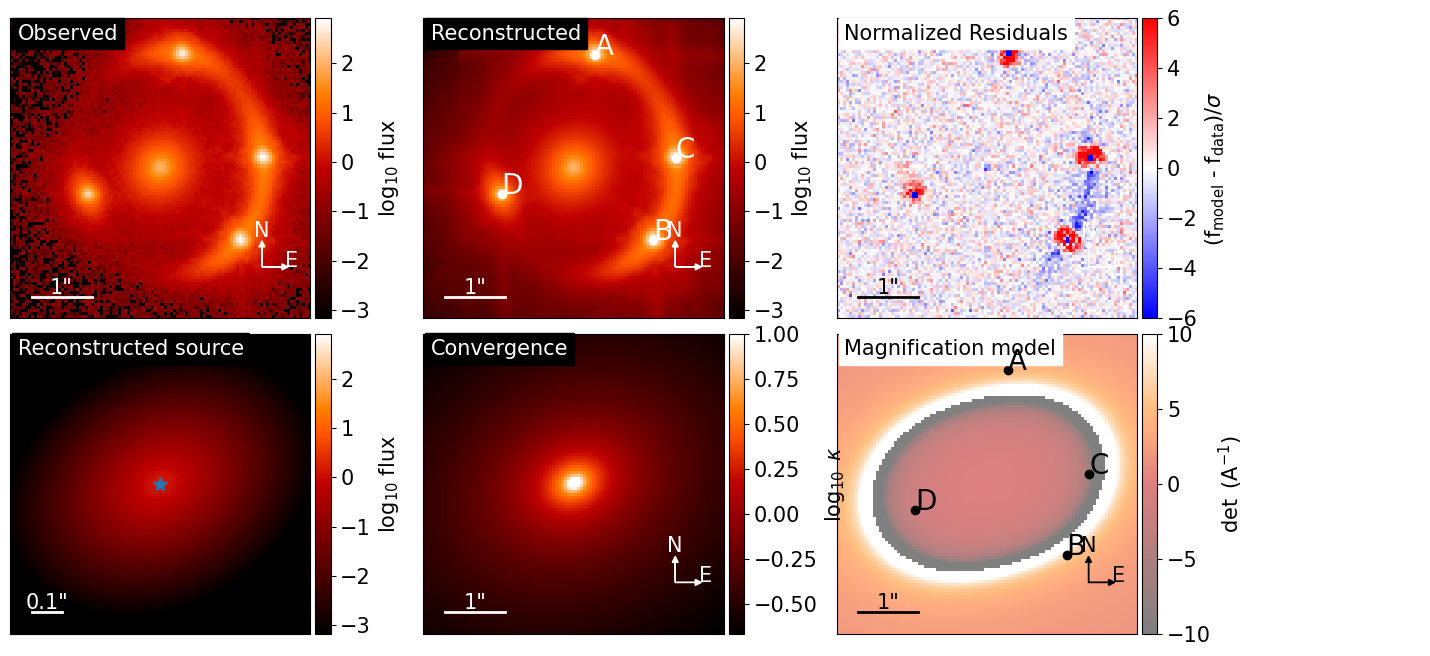

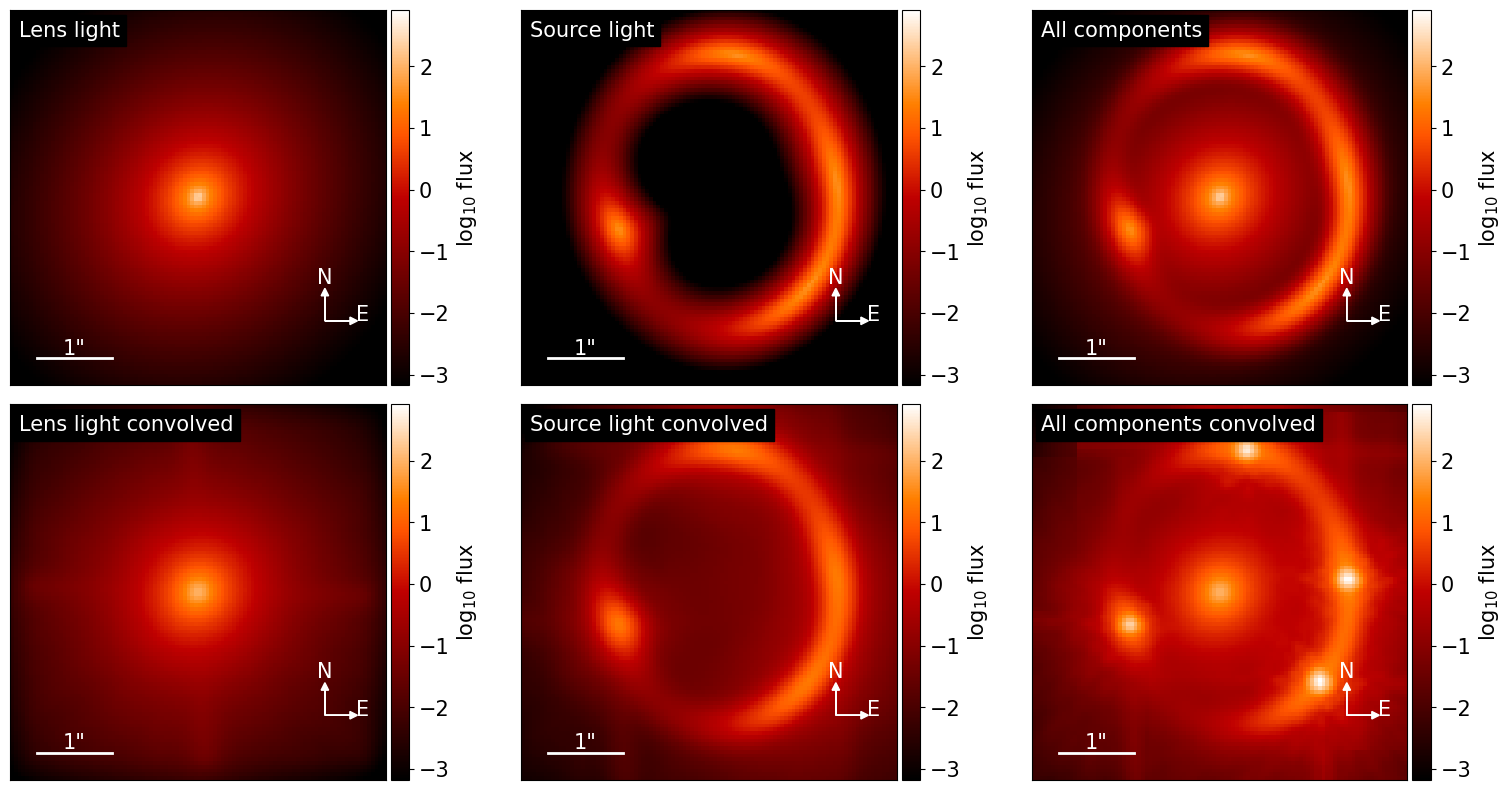

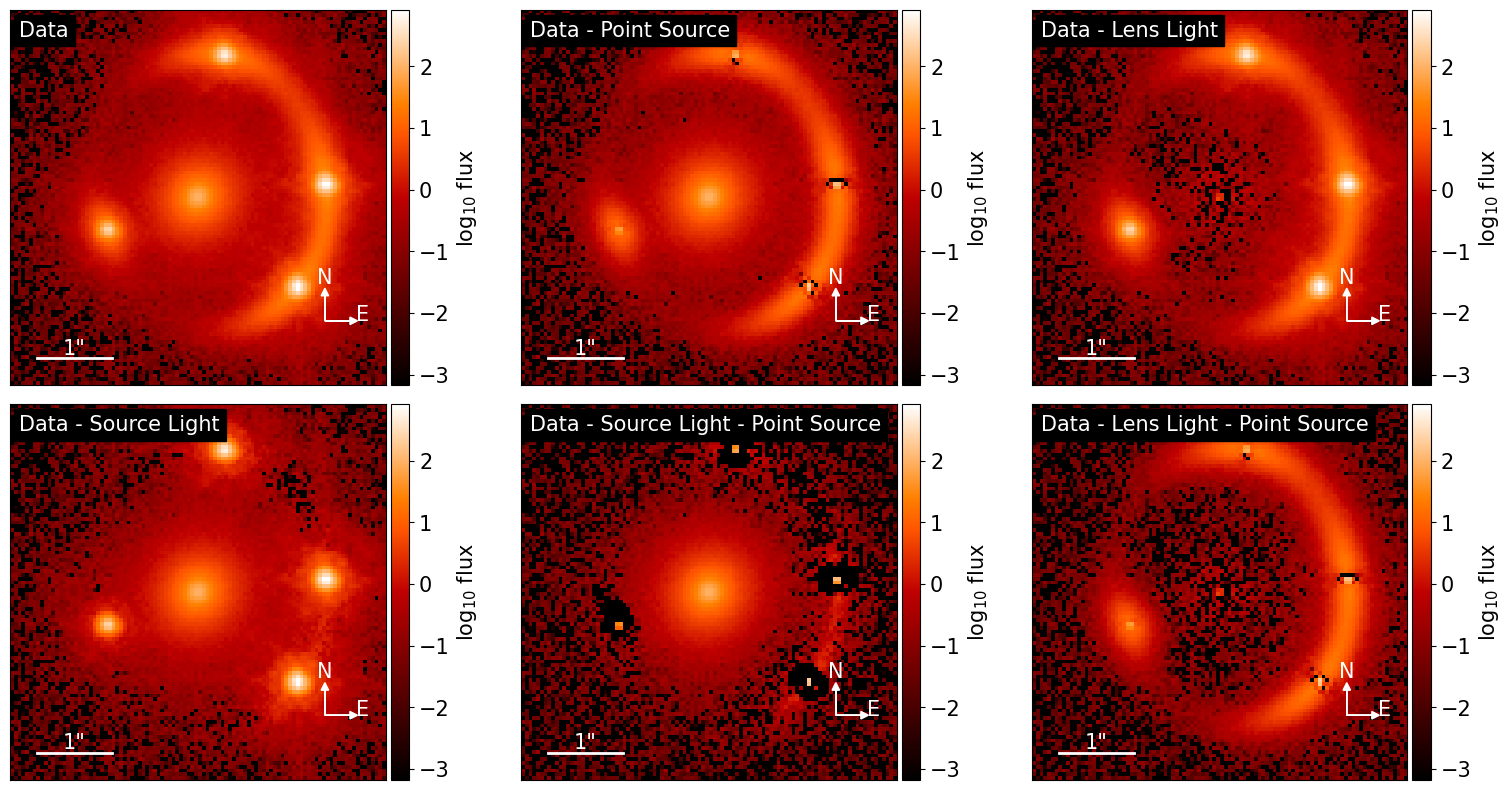

In [6]:
# now we first run a PSO with the wrong PSF
psf_iter_factor = 0.2
psf_iter_num = 100
sigma_scale = 0.1
# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                      'num_point_source_list': [4],
                      'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                      'Ddt_sampling': True,
                              }

kwargs_likelihood = {'check_bounds': True,
                             'force_no_add_image': False,
                             'source_marg': False,
                             'image_position_uncertainty': 0.004,
                             'source_position_likelihood': True,
                             'source_position_tolerance': 0.001,
                             'time_delay_likelihood': True,
                             }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear',
                    'time_delays_measured': dt_measured,
                    'time_delays_uncertainties': dt_sigma,}

kwargs_init = [kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps]

from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_kwargs_list = [['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}],
                       ['PSO', {'sigma_scale': sigma_scale, 'n_particles': 100, 'n_iterations': 100}],]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

# here is the output

from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main(); f.show()
f, axes = modelPlot.plot_separate(); f.show()
f, axes = modelPlot.plot_subtract_from_data_all(); f.show()

iteration of step 100 gave best reconstruction.
log likelihood before: -17450.373835978615 and log likelihood after: -10658.871120993788
-2.131774224198758 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  2.1317742241987565


/home/charlie/Documents/Wolfram/lib/python3.12/site-packages/lenstronomy/Plots/chain_plot.py:200: RuntimeWarning: divide by zero encountered in log10
  np.log10(psf_variance_map * psf.kernel_point_source**2),
/tmp/ipykernel_245454/1471949165.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/tmp/ipykernel_245454/1471949165.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/tmp/ipykernel_245454/1471949165.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/tmp/ipykernel_245454/1471949165.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


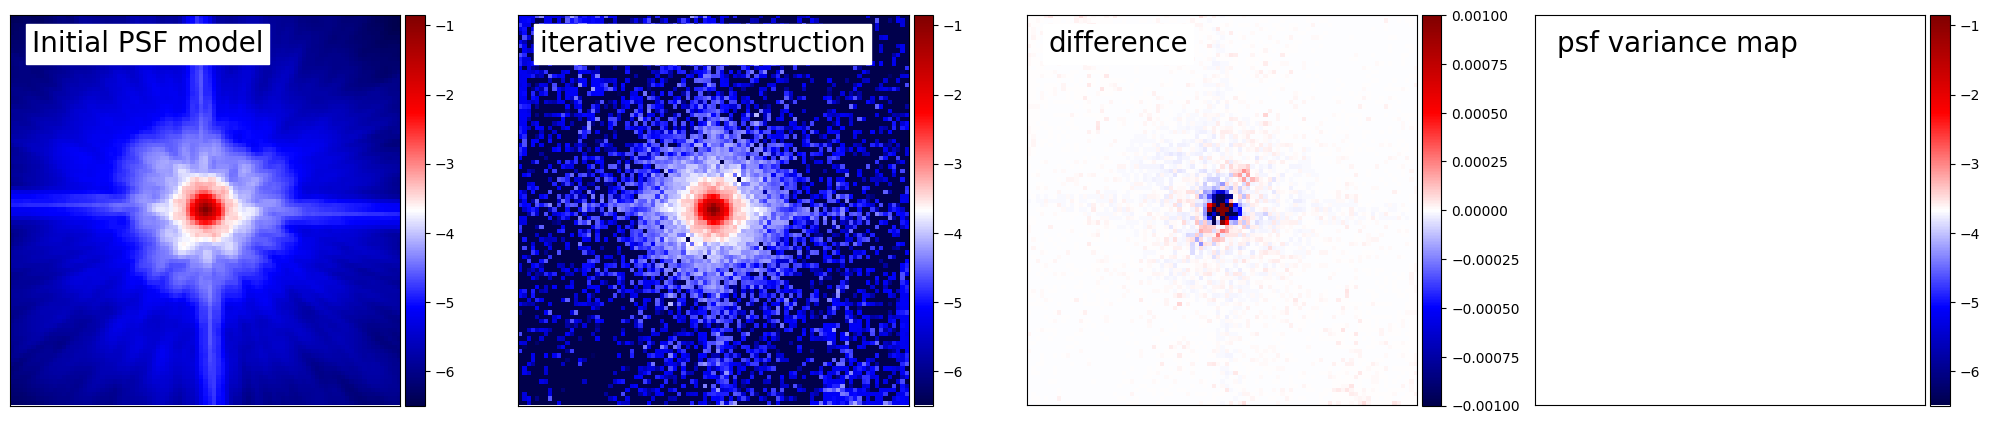

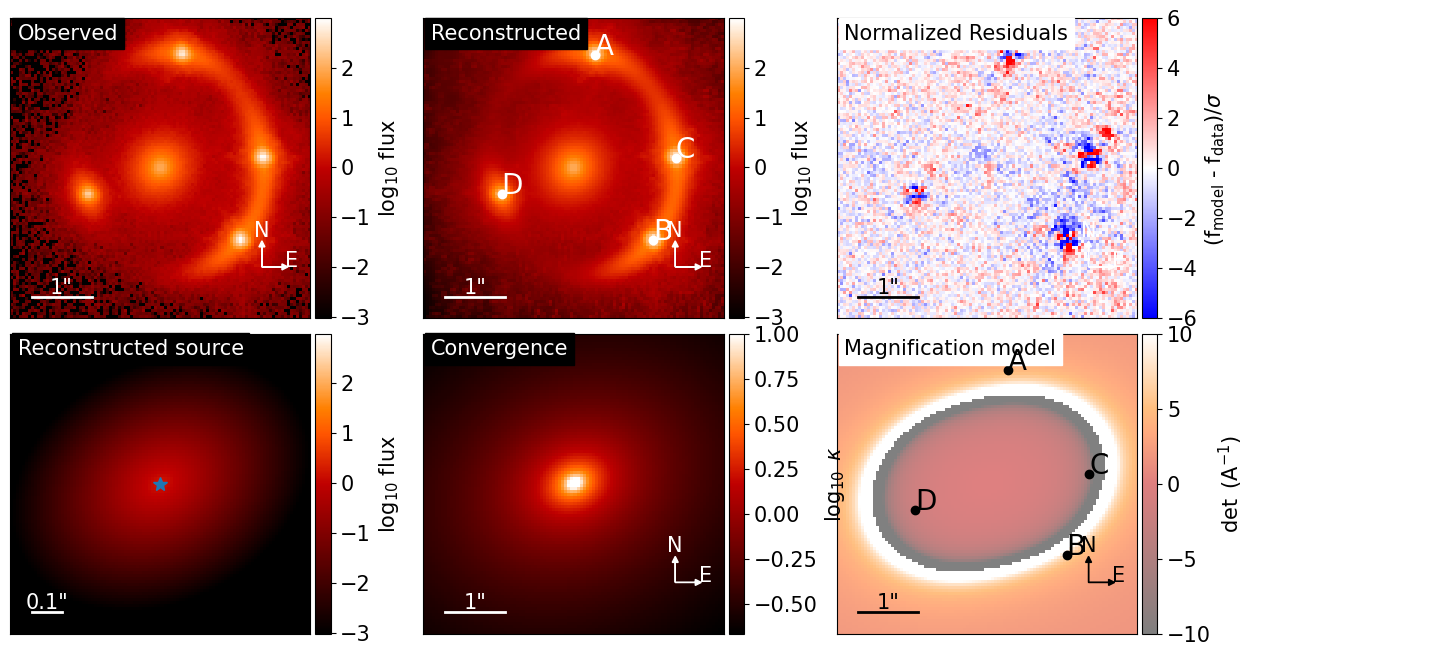

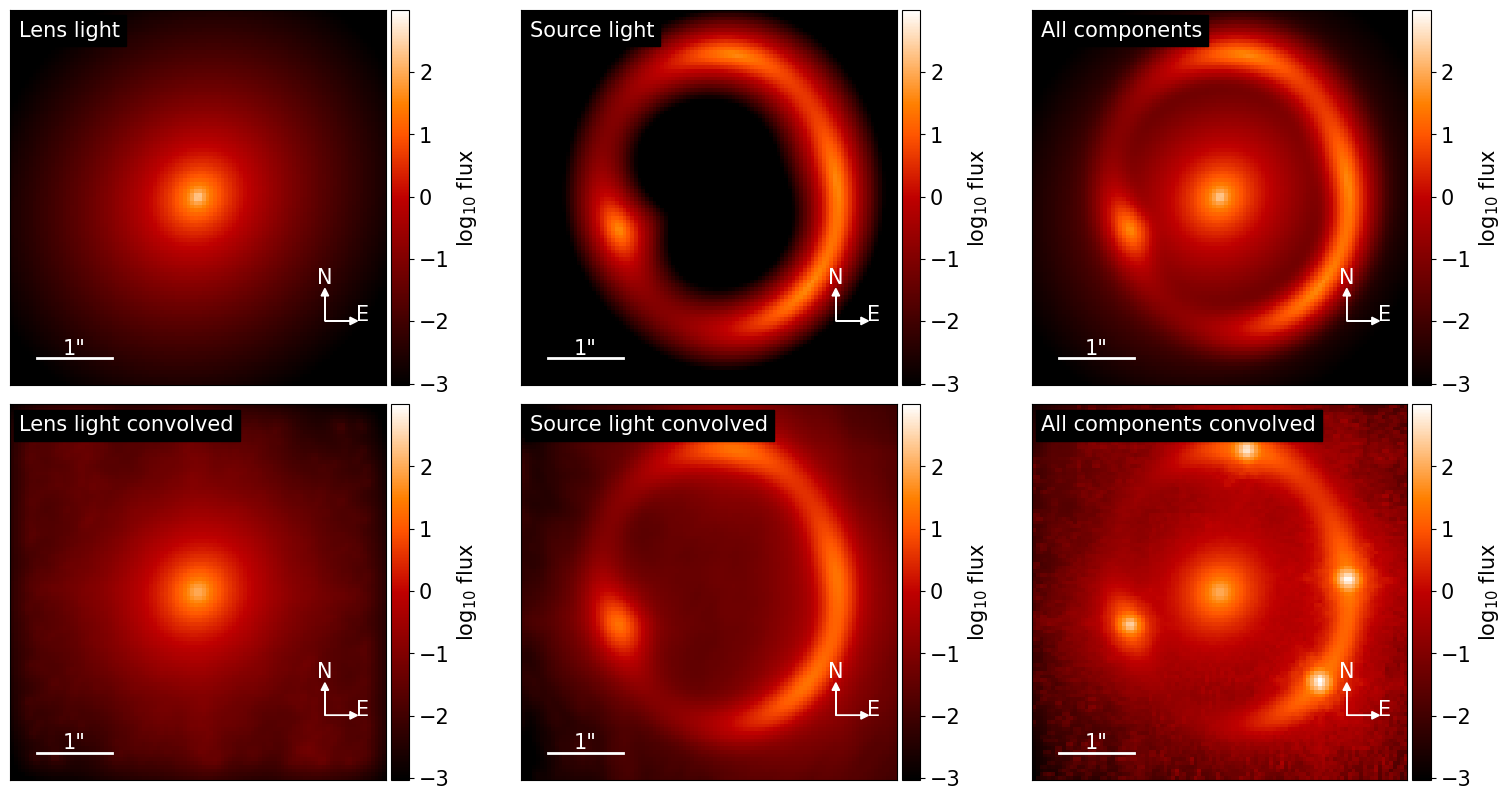

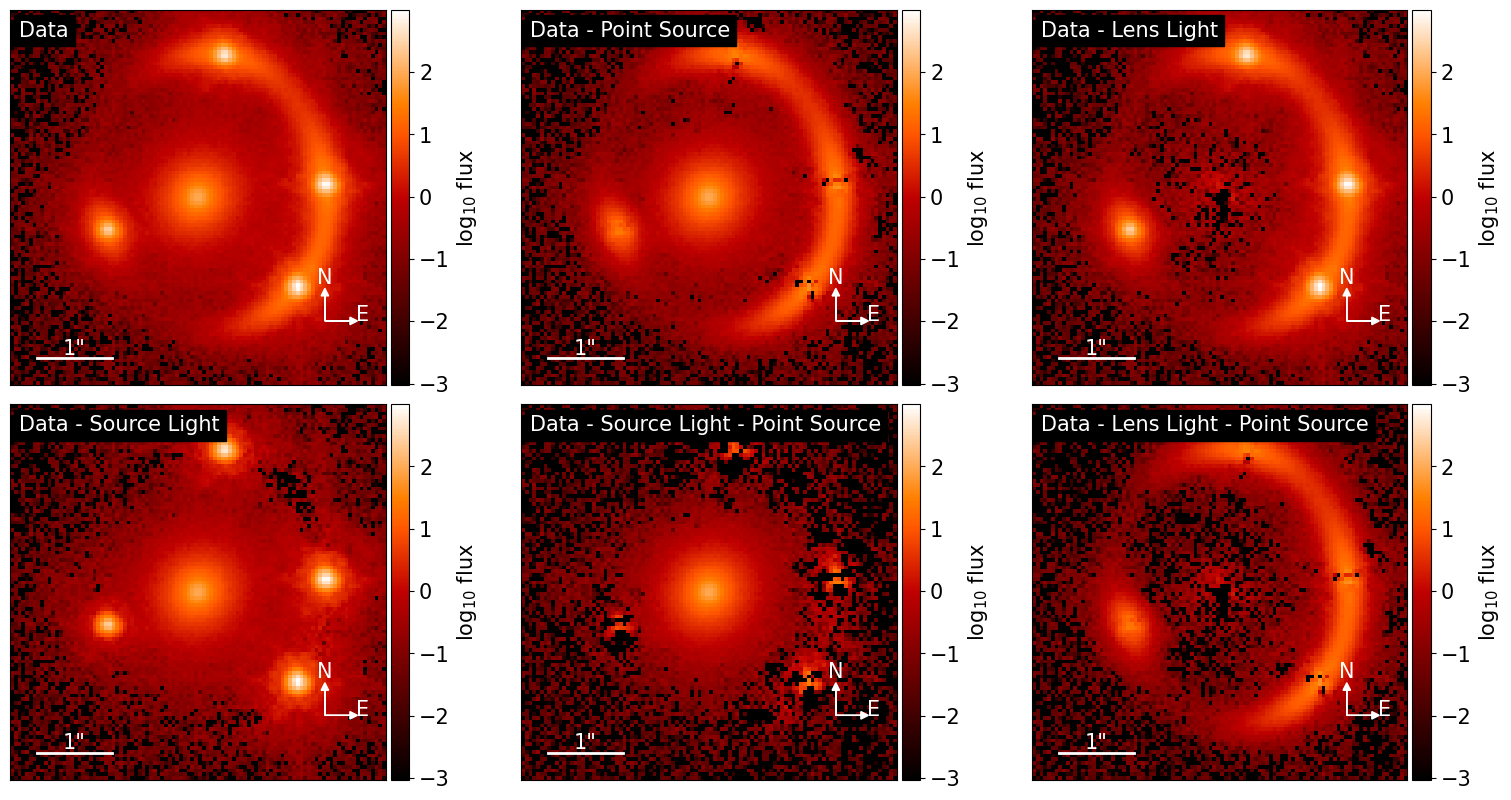

In [8]:
#now we run an iterative PSF reconstruction with the best fit model of the previous run
kwargs_psf_iter = {'stacking_method': 'median', 
                   'keep_psf_variance_map': True, 
                   'psf_symmetry': 2, 
                   'block_center_neighbour': 0.05,
                   'num_iter': psf_iter_num, 
                   'psf_iter_factor': psf_iter_factor}

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
#lens_result, source_result, lens_light_result, ps_result, cosmo_result

multi_band_list = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]
f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()



Computing the PSO ...


100%|████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


Max iteration reached! Stopping.
-2.027888335328799 reduced X^2 of best position
-10112.065184117055 log likelihood
9973 effective number of data points
[{'theta_E': np.float64(1.655394636519609), 'gamma': np.float64(1.9942264526936648), 'e1': np.float64(0.08766277551658917), 'e2': np.float64(0.09402329039882056), 'center_x': np.float64(0.01028592996859433), 'center_y': np.float64(0.005921611886731564)}, {'gamma1': np.float64(-0.0607085558786688), 'gamma2': np.float64(-0.006378182832073486), 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.10174760809702565), 'n_sersic': np.float64(0.9733310194423664), 'e1': np.float64(0.06677238772768054), 'e2': np.float64(0.10443346674719657), 'center_x': np.float64(0.21199356542341471), 'center_y': np.float64(0.10577721929786946)}] source result
[{'amp': 1, 'R_sersic': np.float64(0.19888186508154657), 'n_sersic': np.float64(2.053198920863551), 'e1': np.float64(-0.006841177465391427), 'e2': np.float64(0.04895995748345998), 'ce

100%|████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


Max iteration reached! Stopping.
-0.9552737487539664 reduced X^2 of best position
-4763.472548161653 log likelihood
9973 effective number of data points
[{'theta_E': np.float64(1.656836297938439), 'gamma': np.float64(1.9794062791157767), 'e1': np.float64(0.09165784754266637), 'e2': np.float64(0.09599812676973872), 'center_x': np.float64(0.006934125409474881), 'center_y': np.float64(0.004160309599072689)}, {'gamma1': np.float64(-0.05724723346680319), 'gamma2': np.float64(-0.004274180399877691), 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.10009705201298212), 'n_sersic': np.float64(0.9468089030902065), 'e1': np.float64(0.06837317184850143), 'e2': np.float64(0.09904313151386124), 'center_x': np.float64(0.208024577671726), 'center_y': np.float64(0.10401961515339168)}] source result
[{'amp': 1, 'R_sersic': np.float64(0.19447528738114495), 'n_sersic': np.float64(1.961606372492824), 'e1': np.float64(-0.006136560781617387), 'e2': np.float64(0.05216557189719525), 'ce

/tmp/ipykernel_245454/2237333045.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/tmp/ipykernel_245454/2237333045.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/tmp/ipykernel_245454/2237333045.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/tmp/ipykernel_245454/2237333045.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


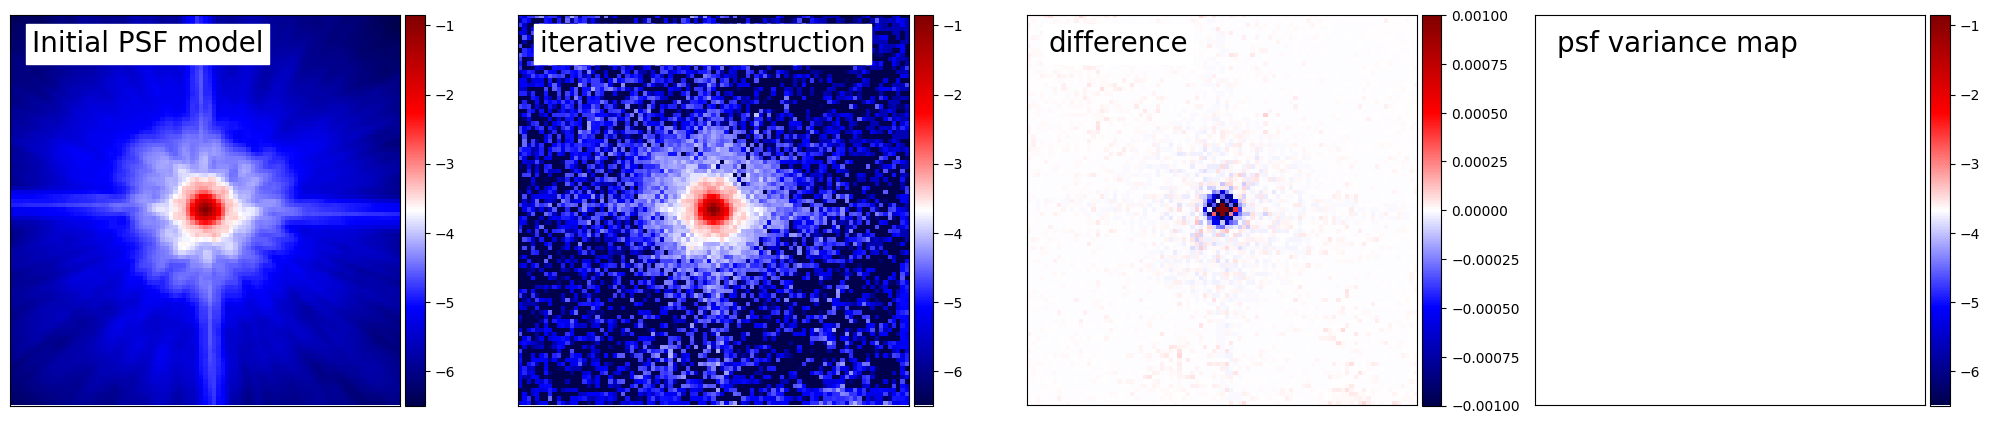

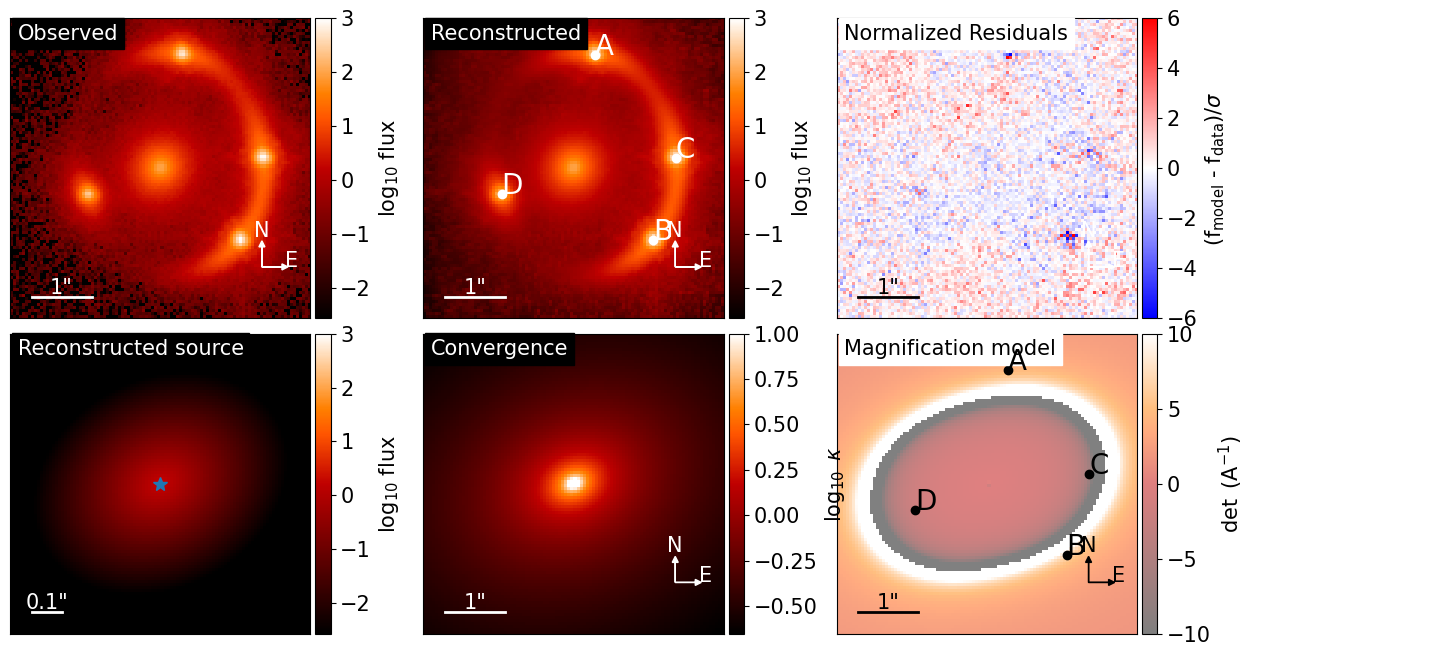

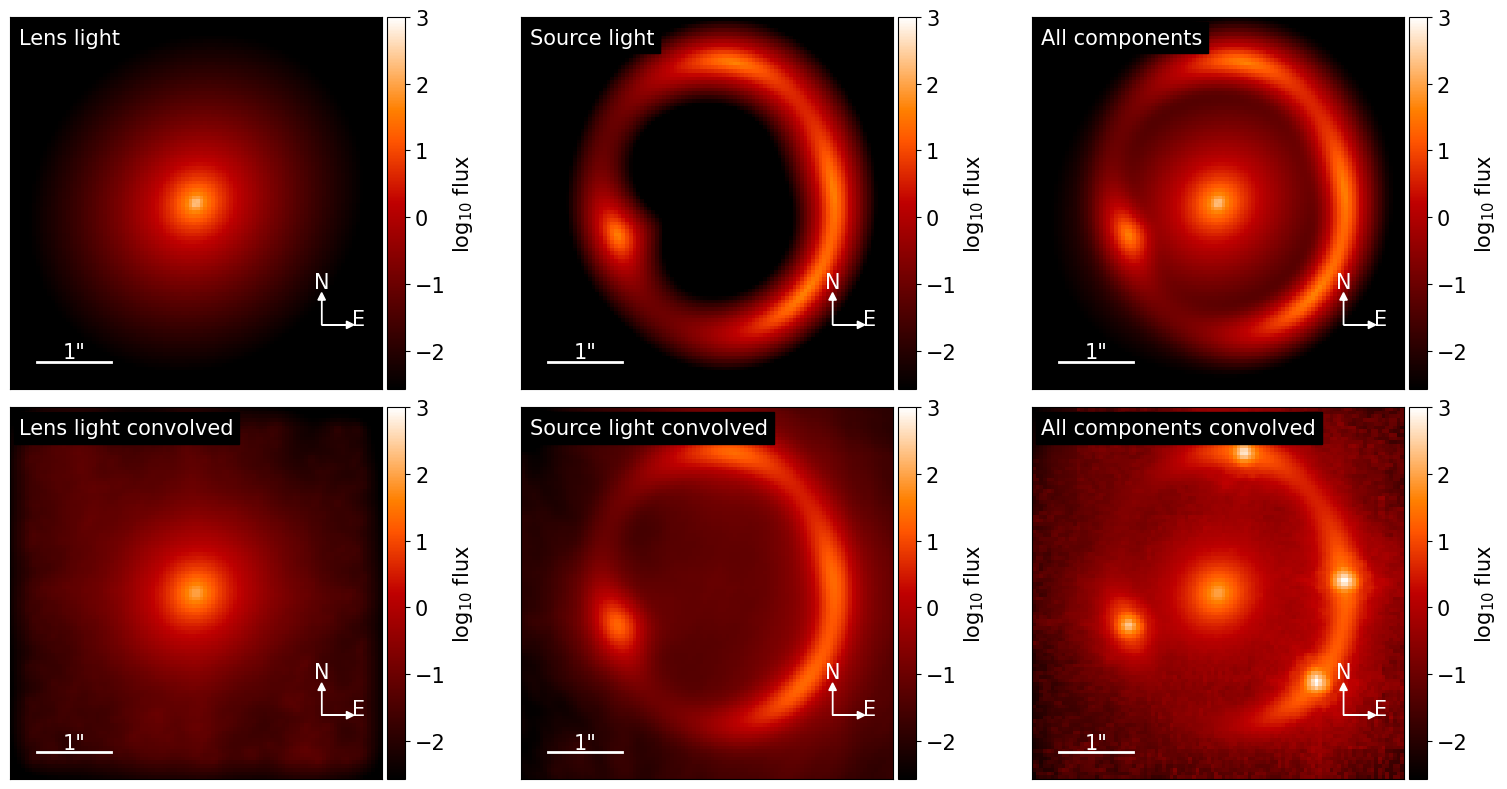

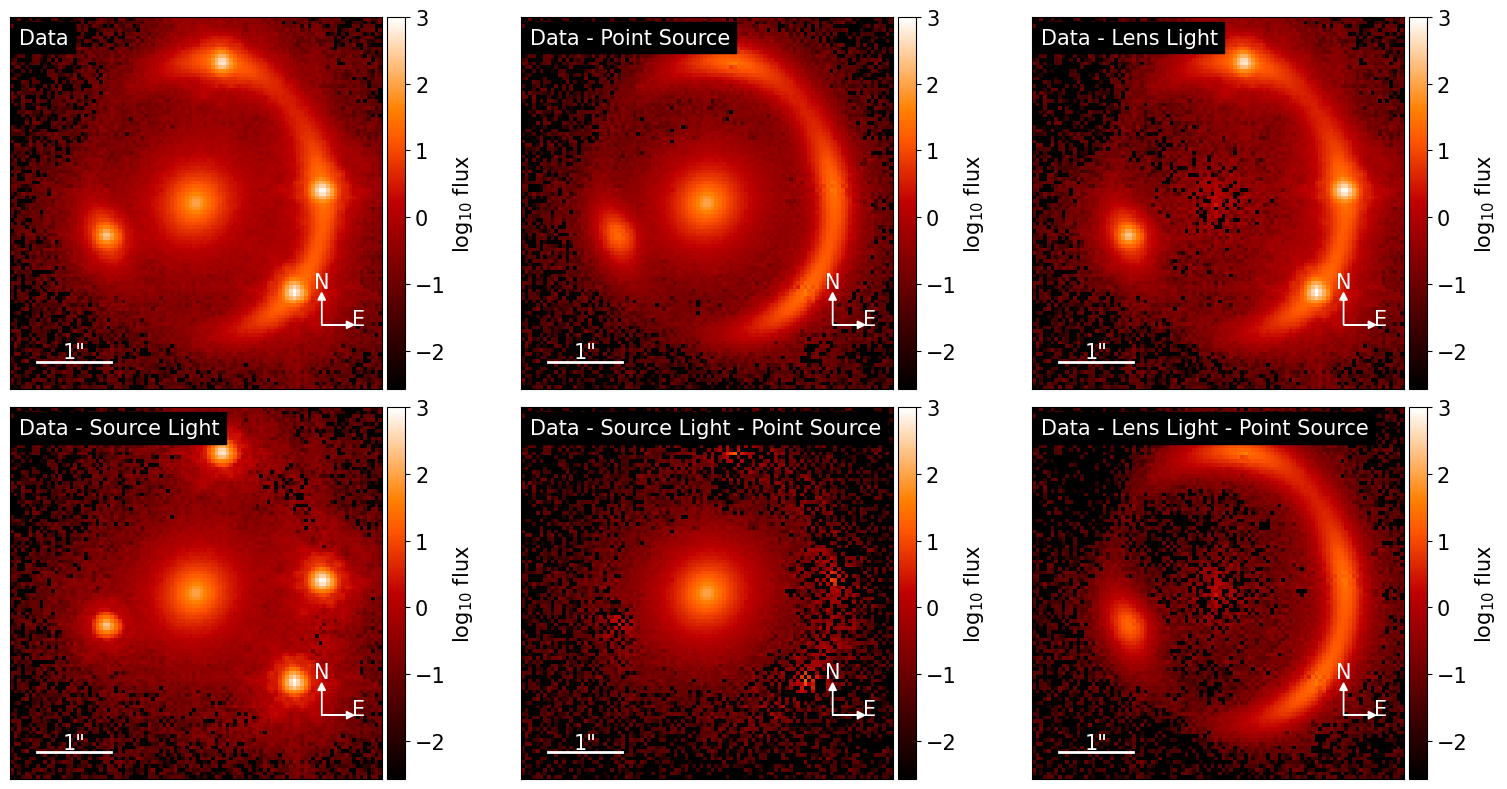

In [9]:
kwargs_psf_iter = {'stacking_method': 'median', 
                   'keep_psf_variance_map': True, 
                   'psf_symmetry': 1, 
                   'block_center_neighbour': 0.05,
                   'num_iter': psf_iter_num, 
                   'psf_iter_factor': psf_iter_factor}

# and now we run another PSO optimization followed by another PSF iteration
fitting_kwargs_list = [['update_settings', {'lens_remove_fixed': [[0, ['gamma']]]}],
    ['PSO', {'sigma_scale': sigma_scale, 'n_particles': 100, 'n_iterations': 100}],
    ['psf_iteration', kwargs_psf_iter],
    ['PSO', {'sigma_scale': sigma_scale, 'n_particles': 100, 'n_iterations': 100}],
    ['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

multi_band_list = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]
f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()

Computing the PSO ...


100%|████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


Max iteration reached! Stopping.
-0.9498766429152179 reduced X^2 of best position
-4736.559879896734 log likelihood
9973 effective number of data points
[{'theta_E': np.float64(1.6576408400518694), 'gamma': np.float64(1.959739498856221), 'e1': np.float64(0.09143002645389016), 'e2': np.float64(0.09555854407615894), 'center_x': np.float64(0.00562867739579447), 'center_y': np.float64(0.0036953264240174996)}, {'gamma1': np.float64(-0.05451671123299082), 'gamma2': np.float64(-0.0025422987920216337), 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.09821320347732344), 'n_sersic': np.float64(0.942877368893201), 'e1': np.float64(0.06731558675550298), 'e2': np.float64(0.09829588488548992), 'center_x': np.float64(0.2032704765295377), 'center_y': np.float64(0.1018530130884658)}] source result
[{'amp': 1, 'R_sersic': np.float64(0.1937199448867807), 'n_sersic': np.float64(1.9437925094061879), 'e1': np.float64(-0.006882243501672609), 'e2': np.float64(0.052649203937699826), 'c

100%|████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]
/tmp/ipykernel_245454/4013513248.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


Computing the MCMC...
Number of walkers =  220
Burn-in iterations:  50
Sampling iterations (in current run): 100
167.04794430732727 time taken for MCMC sampling
-0.9478489979551273 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9478489979551272


/tmp/ipykernel_245454/4013513248.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/tmp/ipykernel_245454/4013513248.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/tmp/ipykernel_245454/4013513248.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


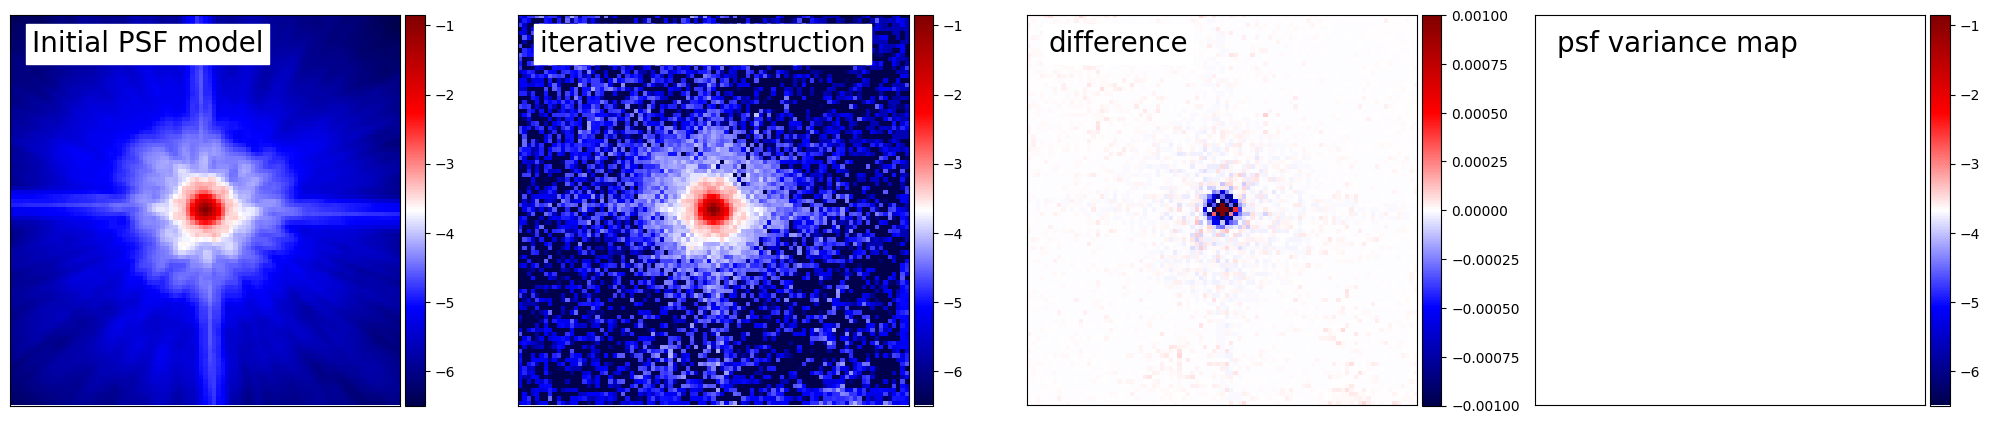

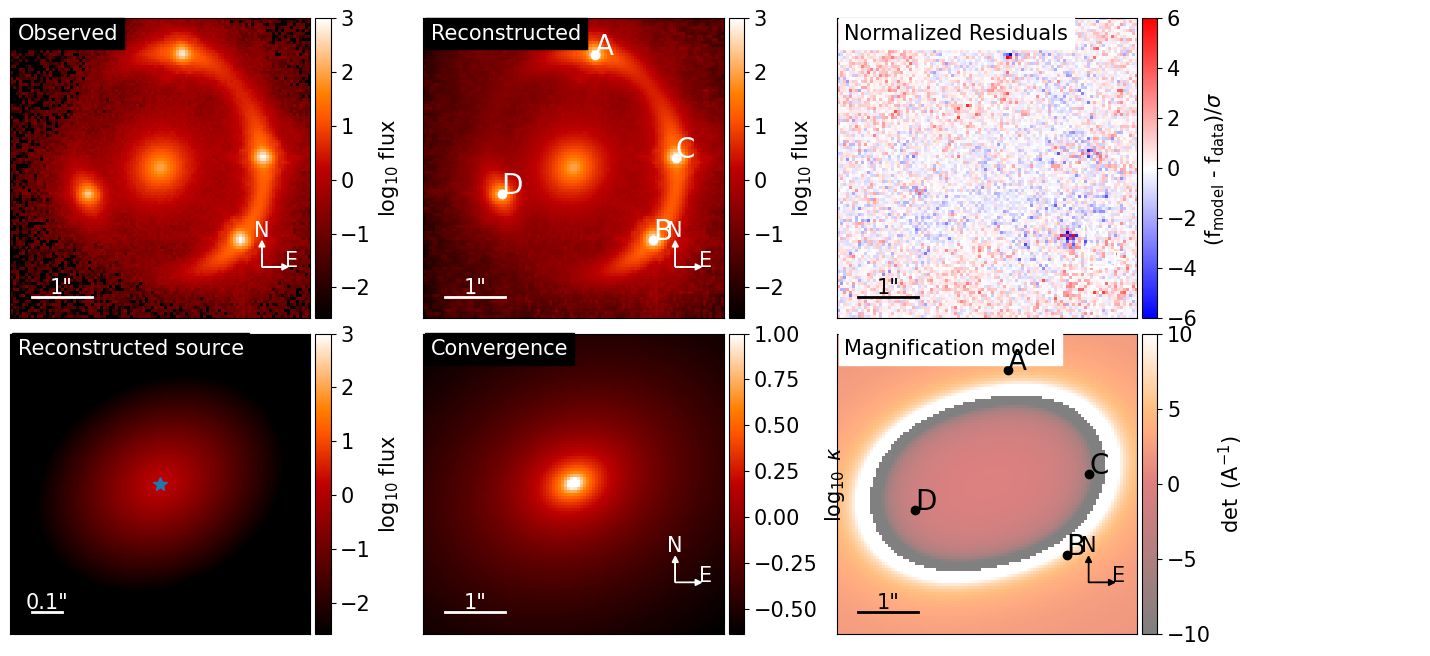

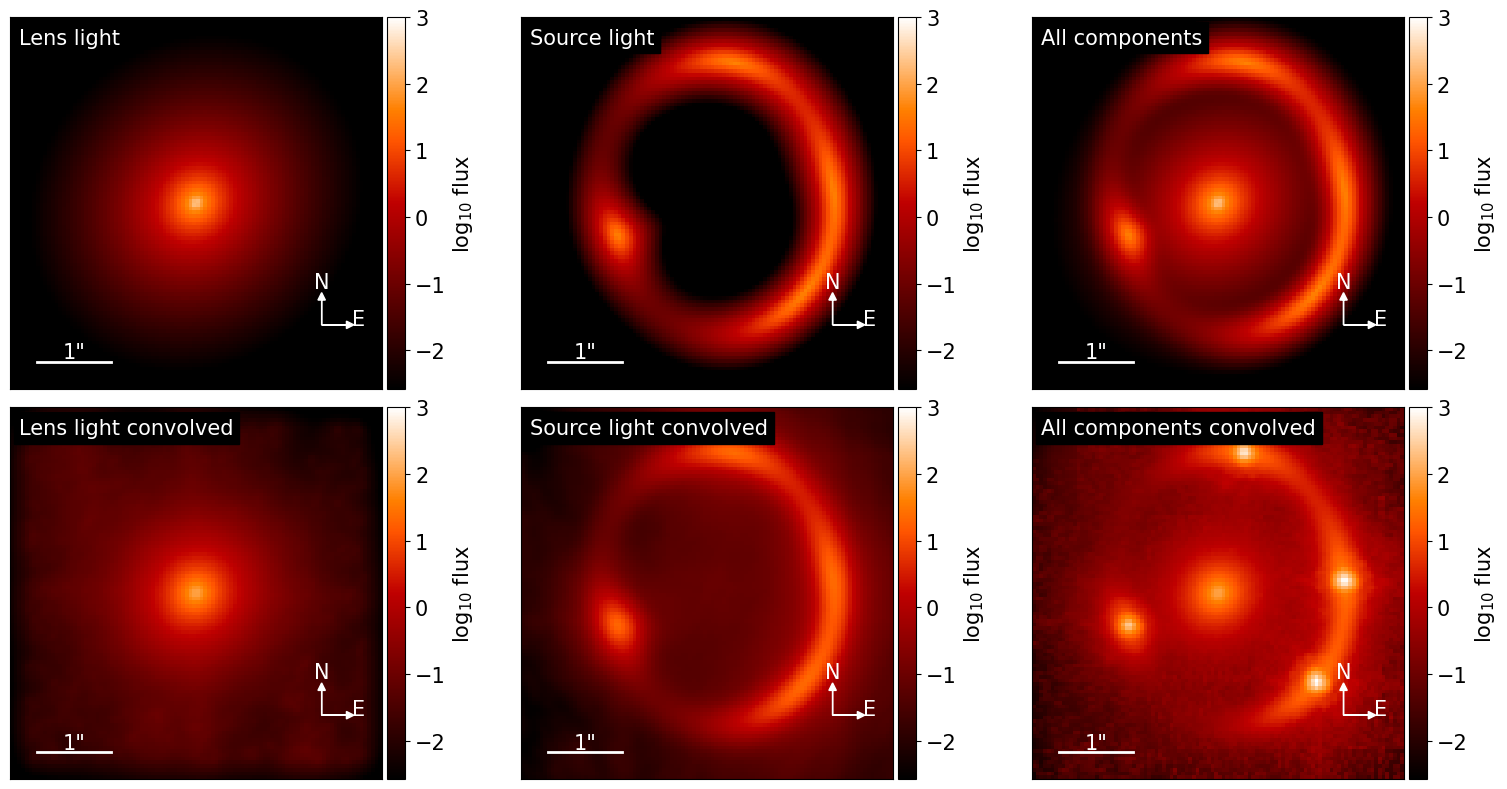

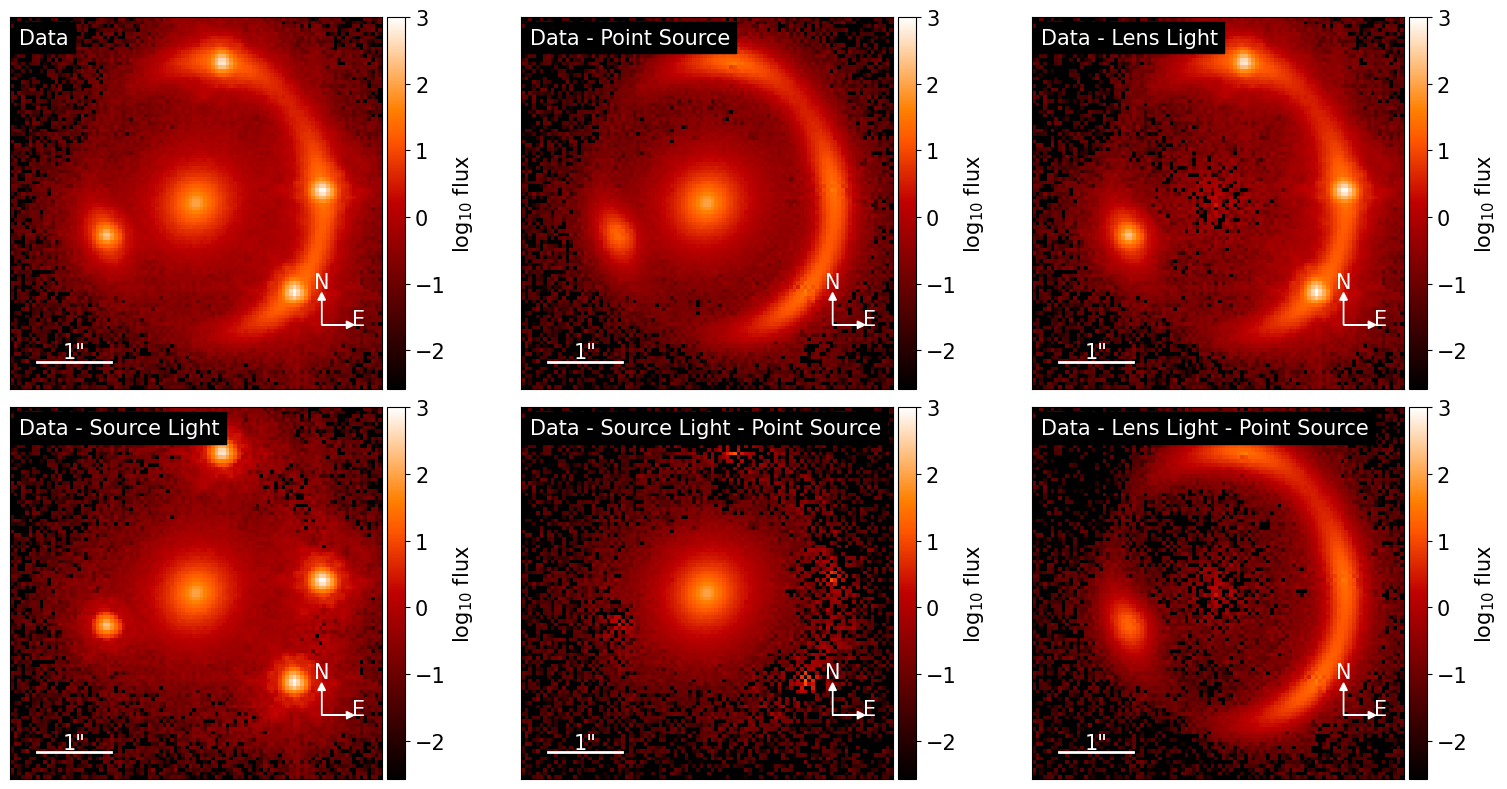

In [10]:
#and now we run the MCMC
fitting_kwargs_list = [
    ['PSO', {'sigma_scale': .1, 'n_particles': 100, 'n_iterations': 100}],
    ['MCMC', {'n_burn': 50, 'n_run': 50, 'walkerRatio': 10,'sigma_scale': .1}]
]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

multi_band_list = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]
f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()

number of non-linear parameters in the MCMC process:  22
parameters in order:  ['gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  11000
3329.6653609254795


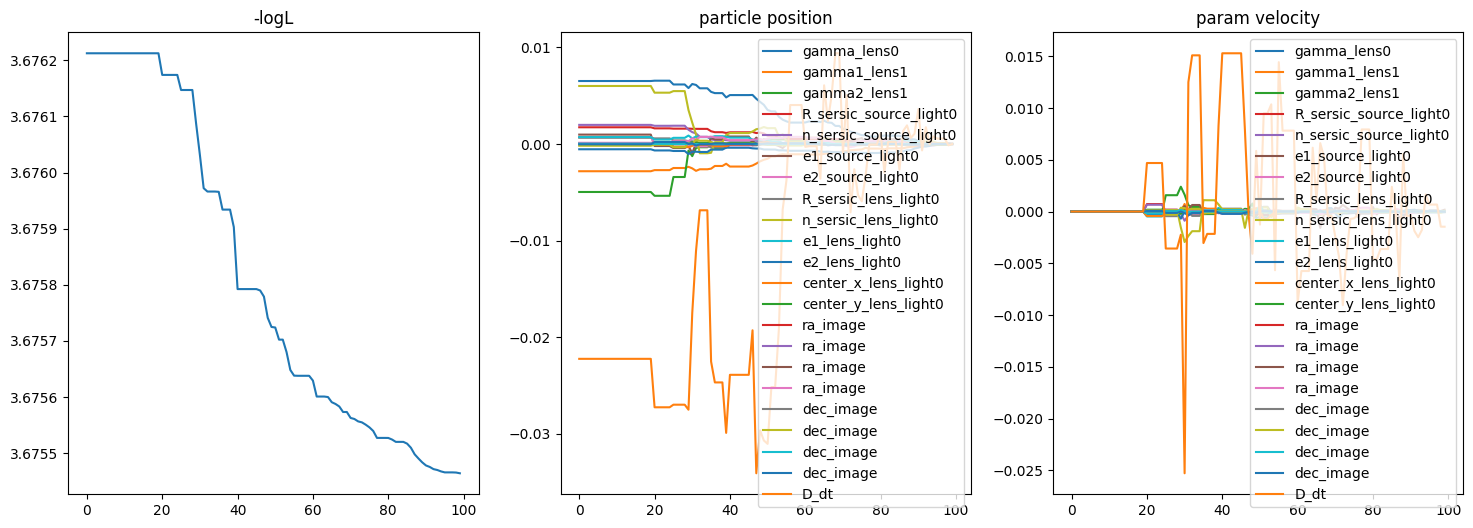

<Figure size 640x480 with 0 Axes>

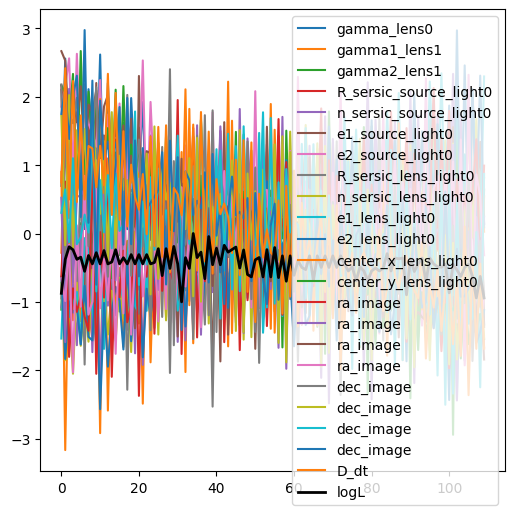

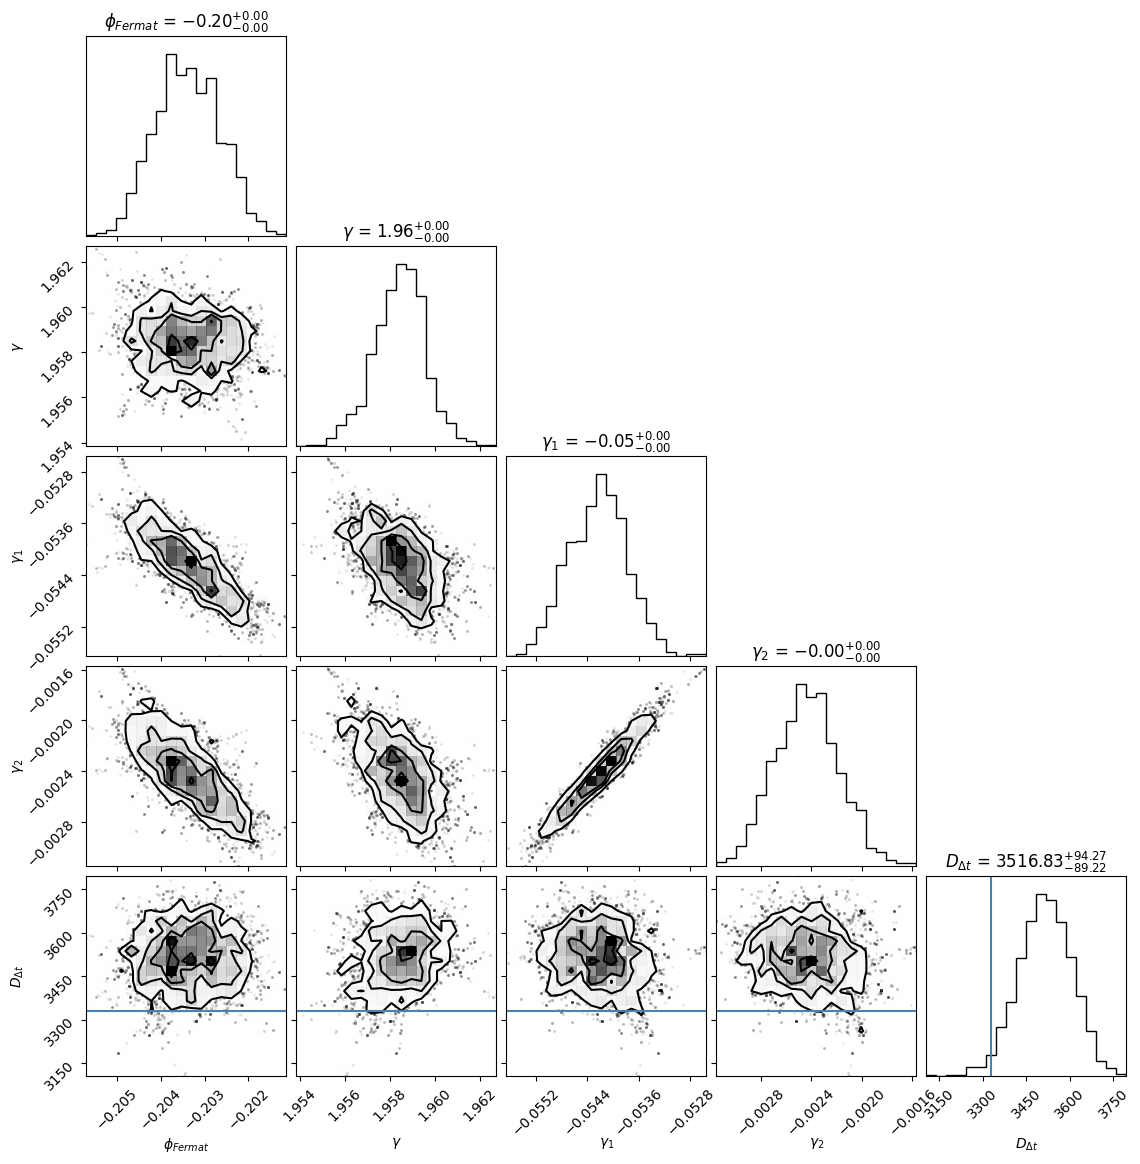

In [11]:
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, fixed_lens, fixed_source, fixed_lens_light, fixed_ps, fixed_cosmo, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

mcmc_new_list = []
labels_new = [r"$\phi_{Fermat}$", r"$\gamma$", r"$\gamma_1$", r"$\gamma_2$", r"$D_{\Delta t}$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    D_dt = kwargs_result['kwargs_special']['D_dt']
    fermat_pot = td_cosmo.fermat_potential(kwargs_result['kwargs_lens'], kwargs_result['kwargs_ps'])
    delta_fermat_12 = fermat_pot[0] - fermat_pot[2]
    gamma = kwargs_result['kwargs_lens'][0]['gamma']
    gamma1, gamma2, = kwargs_result['kwargs_lens'][1]['gamma1'], kwargs_result['kwargs_lens'][1]['gamma2']
    mcmc_new_list.append([delta_fermat_12, gamma, gamma1, gamma2, D_dt])

from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
print(lensCosmo.ddt)
fermat_pot = td_cosmo.fermat_potential(kwargs_lens, kwargs_ps)
delta_fermat_12_true = fermat_pot[0] - fermat_pot[2]

truths=[delta_fermat_12_true, kwargs_lens[0]["gamma"], kwargs_lens[1]["gamma1"], kwargs_lens[1]["gamma2"], lensCosmo.ddt]

plot = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True, truths=truths)